In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2021-05-28 06:36:54--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  3.09MB/s    in 1.5s    

2021-05-28 06:36:56 (3.09 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [21]:
data = pd.read_csv("ml-100k/u1.base", sep='\t',names="userId,movieId,rating,timestamp".split(",")) 
u1_data = data.copy()
u1_data

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [22]:
user_ids = u1_data["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
print('This is user-to-encodeduser')
print(list(user2user_encoded.items())[:10])

userencoded2user = {i: x for i, x in enumerate(user_ids)}
print('This is encodeduser-to-user')
print(list(userencoded2user.items())[:10])

This is user-to-encodeduser
[(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9)]
This is encodeduser-to-user
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]


In [47]:
movie_ids = np.arange(1, 1683)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('This is encodedmovie-to-movie')
print(list(movie2movie_encoded.items())[:10])

movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
print('This is movie-to-encodedmovie')
print(list(movie_encoded2movie.items())[:10])

This is encodedmovie-to-movie
[(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9)]
This is movie-to-encodedmovie
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]


In [48]:
u1_data["user"] = u1_data["userId"].map(user2user_encoded)
u1_data["movie"] = u1_data["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
u1_data["rating"] = u1_data["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later

min_rating = min(u1_data["rating"])
max_rating = max(u1_data["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1682, Min rating: 1.0, Max rating: 5.0


In [49]:
x = u1_data[["user", "movie"]].values
x

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [ 942, 1187],
       [ 942, 1227],
       [ 942, 1329]])

In [50]:
# Normalize the targets between 0 and 1. Makes it easy to train.
y = u1_data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([1.  , 0.5 , 0.75, ..., 0.5 , 0.5 , 0.5 ])

In [51]:
test = pd.read_csv("ml-100k/u1.test", sep='\t',names="userId,movieId,rating,timestamp".split(","))
test

,userId,movieId,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [52]:
test["user"] = test["userId"].map(user2user_encoded)
test["movie"] = test["movieId"].map(movie2movie_encoded)
test

,userId,movieId,rating,timestamp,user,movie
0,1,6,5,887431973,0,5
1,1,10,3,875693118,0,9
2,1,12,5,878542960,0,11
3,1,14,5,874965706,0,13
4,1,17,3,875073198,0,16
...,...,...,...,...,...,...
19995,458,648,4,886395899,457,647
19996,458,1101,4,886397931,457,1100
19997,459,934,3,879563639,458,933
19998,460,10,3,882912371,459,9


In [53]:
x_test = test[["user", "movie"]].values
y_test = test["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [54]:
x_train = x
x_val =  x_test
y_train =  y
y_val = y_test

In [58]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [61]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6171 - val_loss: 0.6217
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6169 - val_loss: 0.6210
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6176 - val_loss: 0.6196
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6175 - val_loss: 0.6178
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6181 - val_loss: 0.6180
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6176 - val_loss: 0.6170
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6174 - val_loss: 0.6175
Epoch 8/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6172 - val_loss: 0.6188
Epoch 9/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6179 - val_loss: 0.6190
Epoch 10/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.618

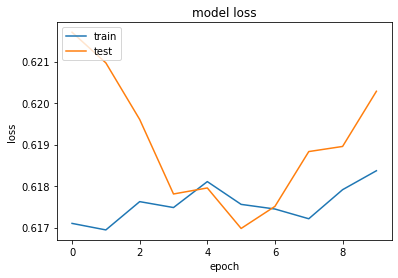

In [62]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [ ]:
from keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)

    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [ ]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=500,
                    verbose=1, validation_data=(X_test_array, y_test))



Train on 75627 samples, validate on 25209 samples
Epoch 1/500
75627/75627 [==============================] - 9s 117us/step - loss: 1.2574 - val_loss: 0.9033
Epoch 2/500
75627/75627 [==============================] - 5s 64us/step - loss: 0.7293 - val_loss: 0.7625
Epoch 3/500
75627/75627 [==============================] - 5s 63us/step - loss: 0.5393 - val_loss: 0.7379
Epoch 4/500
75627/75627 [==============================] - 5s 61us/step - loss: 0.4032 - val_loss: 0.7415
Epoch 5/500
75627/75627 [==============================] - 5s 62us/step - loss: 0.3066 - val_loss: 0.7558
Epoch 6/500
75627/75627 [==============================] - 5s 61us/step - loss: 0.2380 - val_loss: 0.7733
Epoch 7/500
75627/75627 [==============================] - 5s 62us/step - loss: 0.1896 - val_loss: 0.7934
Epoch 8/500
75627/75627 [==============================] - 5s 61us/step - loss: 0.1544 - val_loss: 0.8120
Epoch 9/500
75627/75627 [==============================] - 5s 64us/step - loss: 0.1283 - val_loss: 